In [1]:
'''this notebook is used to clean and aggregate the Houston Crime Statistics data set from 2009-2020 YTD'''
import os
import calendar
import pandas as pd
import warnings

In [2]:
#rename all 2018 monthly data to the standard filename of mmmYY
result = os.walk('.\\temp')
file_names = tuple(result)[0][2]
for item in file_names:
    if item.find('NIBRS_Public_Data') != -1:
        os.rename(r'.\\temp\\' + item , r'.\\temp\\' + calendar.month_name[int(item[0:2])].lower()[0:3] + '18.xlsx' )

In [3]:
#use os walk to update the list of file names, after the 2018 monthly data has been renamed
result = os.walk('.\\temp')
file_names = tuple(result)[0][2]
#the file names we don't want are more than 15 characters in length
file_names = [x for x in file_names if len(x) <= 15]
#create a dictionary to map mmm month names to numeric strings:
mth_dict = {}
for i in range(1,13):
    if len(str(i)) <2:
        mth = "0" + str(i)
    else:
        mth = str(i)
    mth_dict[calendar.month_name[i][0:3].lower()] = mth
    
#create a dictionary to map file names to date, for 2009 to 2020:
date_dict = {}
for i in range(9, 21):
    if len(str(i)) < 2:
        yr = "0" + str(i)
    else:
        yr = str(i)
    for k in mth_dict.keys():
        date_dict[k+yr] = '20'+ yr + '-' + mth_dict[k]

In [4]:
#create data set for 2009 to 2018
warnings.filterwarnings('ignore')
robberies = []
dates = []
#the files come in three different formats, with the type of crime listed as 'Offense Type', 'NIBRS Description' and
#'NIBRSDescription'. Loop through all possibilities for try/except:
def label_f1(filepath):
    try:
        placeholder = pd.read_excel(filepath, index_col=0, header=0)
        placeholder['Offense Type'] = placeholder['Offense Type'].str.strip()
        crime_count = placeholder['Offense Type'][placeholder['Offense Type'] == 'Robbery'].value_counts()
    except:
        return label_f2(filepath)
    return crime_count

def label_f2(filepath):
    try:
        placeholder = pd.read_excel(filepath, index_col=0, header=11)
        placeholder['NIBRS Description'] = placeholder['NIBRS Description'].str.strip()
        crime_count = placeholder['NIBRS Description'][placeholder['NIBRS Description'] == 'Robbery'].value_counts()
    except:
        return label_f3(filepath)
    return crime_count

def label_f3(filepath):
    try:
        placeholder = pd.read_excel(filepath, index_col=0, header=0)
        placeholder['NIBRSDescription'] = placeholder['NIBRSDescription'].str.strip()
        crime_count = placeholder['NIBRSDescription'][placeholder['NIBRSDescription'] == 'Robbery'].value_counts()
    except:
        print('Label does not exist.')
        return
    return crime_count

#iterate through list of files, append the count of robberies for each month and the date
for item in file_names:
    crime_count = label_f1('.//temp//' + item)
    try:
        robberies.append(float(crime_count))
        dates.append(date_dict[item[:item.find('.')]])
    except:
        print(crime_count, item)
        continue

#store output as series
raw_data_09_18 = pd.Series(robberies, index=dates)

WARNING *** file size (3085901) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (2845765) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (3078551) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (2971767) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (2752234) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [16]:
#use os walk again to find the data for 2019 and 2020
result = os.walk('.\\temp')
file_names = tuple(result)[0][2]
file_names = [x for x in file_names if x.find('NIBRS') != -1]
robberies = []
dates = []
for item in file_names:
    placeholder = pd.read_excel('.//temp//' + item, index_col=1, header=0)
    #remove newline from header
    placeholder.index = [str(x)[0:7] for x in placeholder.index]
    #remove newline from header
    placeholder.columns = [x.replace('\n','') for x in placeholder.columns]
    # print(placeholder.columns)
    grp = placeholder.groupby([placeholder.index, 'NIBRSDescription'])
    mths = list(placeholder.index.unique())
    for mth in mths:
        crime_count = grp.get_group((mth,'Robbery'))['Incident'].count()
        robberies.append(crime_count)
        dates.append(mth)
        
#store output as series        
raw_data_19_20 = pd.Series(robberies, index=dates)

In [34]:
#concatenate to form final data set
raw_data = pd.concat([raw_data_09_18, raw_data_19_20])
#sort index to ensure that series is chronological
raw_data.sort_index(inplace=True)

In [35]:
#preview series
raw_data.head(20)

2009-06     982.0
2009-07    1081.0
2009-08    1034.0
2009-09    1021.0
2009-10     930.0
2009-11     934.0
2009-12    1026.0
2010-01     866.0
2010-02     640.0
2010-03     826.0
2010-04     763.0
2010-05     852.0
2010-06     827.0
2010-07     830.0
2010-08     805.0
2010-09     748.0
2010-10     742.0
2010-11     742.0
2010-12     808.0
2011-01     705.0
dtype: float64

In [36]:
raw_data.tail(20)

2018-09    659.0
2018-10    672.0
2018-11    776.0
2018-12    813.0
2019-01    764.0
2019-02    564.0
2019-03    660.0
2019-04    727.0
2019-05    864.0
2019-06    754.0
2019-07    837.0
2019-08    822.0
2019-09    713.0
2019-10    732.0
2019-11    863.0
2019-12    900.0
2020-01    910.0
2020-02    721.0
2020-03    681.0
2020-04    456.0
dtype: float64

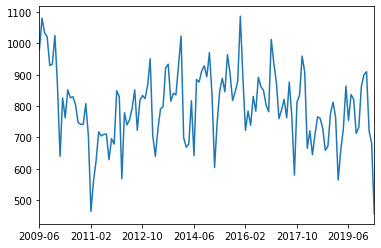

In [37]:
#use matplotlib to preview data set
import matplotlib as plt
raw_data.plot()

In [38]:
#save data as csv in data folder
raw_data.to_csv('.//data//HTX_robberies.csv')